In [1]:
# pip install pyhealth

In [2]:
import sys
sys.path.insert(0, "/shared/chaoqiy2/github/PyHealth")

In [3]:
import torch

device = torch.device("cuda:0")

/home/chaoqiy2/miniconda3/envs/moltext/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. load the chest Xray data by PyHealth

In [4]:
from pyhealth.datasets import COVID19CXRDataset

root = "/shared/chaoqiy2/data/COVID-19_Radiography_Dataset"
base_dataset = COVID19CXRDataset(root, refresh_cache=False)

base_dataset.stat()

Statistics of COVID19CXRDataset:
Number of samples: 21165
Number of classes: 4
Class distribution: Counter({'Normal': 10192, 'Lung Opacity': 6012, 'COVID': 3616, 'Viral Pneumonia': 1345})


## 2. set task and processing the data

In [5]:
from torchvision import transforms

sample_dataset = base_dataset.set_task()

# the transformation automatically normalize the pixel intensity into [0, 1]
transform = transforms.Compose([
    transforms.Lambda(lambda x: x if x.shape[0] == 3 else x.repeat(3, 1, 1)), # only use the first channel
    transforms.Resize((128, 128)),
])

def encode(sample):
    sample["path"] = transform(sample["path"])
    return sample

sample_dataset.set_transform(encode)

Generating samples for COVID19CXRClassification: 100%|█████████████████████| 21165/21165 [00:00<00:00, 3072667.76it/s]


In [6]:
from pyhealth.datasets import split_by_visit, get_dataloader

# split dataset
train_dataset, val_dataset, test_dataset = split_by_visit(
    sample_dataset, [0.8, 0.1, 0.1]
)
train_dataloader = get_dataloader(train_dataset, batch_size=256, shuffle=True, num_workers=10)
val_dataloader = get_dataloader(val_dataset, batch_size=256, shuffle=False, num_workers=10)
test_dataloader = get_dataloader(test_dataset, batch_size=256, shuffle=False, num_workers=10)

In [7]:
data = next(iter(train_dataloader))
print (data["path"][0].shape)

print(
    "loader size: train/val/test",
    len(train_dataset),
    len(val_dataset),
    len(test_dataset),
)

torch.Size([3, 128, 128])
loader size: train/val/test 16932 2116 2117


## 3. build a VAE model first by PyHealth
- note that this VAE model is an auxiliary module for latent diffusion process

In [8]:
from pyhealth.models import VAE

vae = VAE(
    dataset=sample_dataset,
    input_channel=3,
    input_size=128,
    feature_keys=["path"],
    label_key="path",
    mode="regression",
    hidden_dim = 256,
)

In [9]:
from pyhealth.trainer import Trainer

trainer = Trainer(model=vae, device=device, metrics=["kl_divergence", "mse", "mae"])

trainer.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=20,
    monitor = "kl_divergence",
    monitor_criterion = 'min',
    optimizer_params={"lr": 1e-3},
)

VAE(
  (encoder1): Sequential(
    (0): ResBlock2D(
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ELU(alpha=1.0)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (downsample): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): ResBlock2D(
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ELU(alp

Epoch 0 / 20: 100%|███████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.15it/s]

--- Train epoch-0, step-67 ---
loss: 7844969.7108



Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.32it/s]


--- Eval epoch-0, step-67 ---
kl_divergence: 0.1428
mse: 0.0000
mae: 0.0000
loss: 6897203.2222
New best kl_divergence score (0.1428) at epoch-0, step-67



Epoch 1 / 20: 100%|███████████████████████████████████████████████████████████████████| 67/67 [00:12<00:00,  5.55it/s]

--- Train epoch-1, step-134 ---
loss: 7267851.2090



Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.97it/s]


--- Eval epoch-1, step-134 ---
kl_divergence: 0.1039
mse: 0.0000
mae: 0.0000
loss: 6677999.2778
New best kl_divergence score (0.1039) at epoch-1, step-134



Epoch 2 / 20: 100%|███████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.61it/s]

--- Train epoch-2, step-201 ---
loss: 7179636.9160



Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.12it/s]


--- Eval epoch-2, step-201 ---
kl_divergence: 0.0856
mse: 0.0000
mae: 0.0000
loss: 6636794.4444
New best kl_divergence score (0.0856) at epoch-2, step-201



Epoch 3 / 20: 100%|███████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.11it/s]

--- Train epoch-3, step-268 ---
loss: 7140080.6894



Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.21it/s]


--- Eval epoch-3, step-268 ---
kl_divergence: 0.0725
mse: 0.0000
mae: 0.0000
loss: 6593382.0139
New best kl_divergence score (0.0725) at epoch-3, step-268



Epoch 4 / 20: 100%|███████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.08it/s]

--- Train epoch-4, step-335 ---
loss: 7115424.2603



Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.76it/s]


--- Eval epoch-4, step-335 ---
kl_divergence: 0.0704
mse: 0.0000
mae: 0.0000
loss: 6565679.5278
New best kl_divergence score (0.0704) at epoch-4, step-335



Epoch 5 / 20: 100%|███████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.36it/s]

--- Train epoch-5, step-402 ---
loss: 7085686.2910



Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.25it/s]


--- Eval epoch-5, step-402 ---
kl_divergence: 0.0566
mse: 0.0000
mae: 0.0000
loss: 6550994.9861
New best kl_divergence score (0.0566) at epoch-5, step-402



Epoch 6 / 20: 100%|███████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.48it/s]

--- Train epoch-6, step-469 ---
loss: 7070152.5690



Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.18it/s]


--- Eval epoch-6, step-469 ---
kl_divergence: 0.0689
mse: 0.0000
mae: 0.0000
loss: 6556880.4306



Epoch 7 / 20: 100%|███████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  6.09it/s]

--- Train epoch-7, step-536 ---
loss: 7063844.3601



Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.83it/s]


--- Eval epoch-7, step-536 ---
kl_divergence: 0.0506
mse: 0.0000
mae: 0.0000
loss: 6528824.6667
New best kl_divergence score (0.0506) at epoch-7, step-536



Epoch 8 / 20: 100%|███████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.50it/s]

--- Train epoch-8, step-603 ---
loss: 7051496.7024



Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.25it/s]


--- Eval epoch-8, step-603 ---
kl_divergence: 0.0455
mse: 0.0000
mae: 0.0000
loss: 6521630.6806
New best kl_divergence score (0.0455) at epoch-8, step-603



Epoch 9 / 20: 100%|███████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.67it/s]

--- Train epoch-9, step-670 ---
loss: 7043327.9095



Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.35it/s]


--- Eval epoch-9, step-670 ---
kl_divergence: 0.0377
mse: 0.0000
mae: 0.0000
loss: 6512505.9861
New best kl_divergence score (0.0377) at epoch-9, step-670



Epoch 10 / 20: 100%|██████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.37it/s]

--- Train epoch-10, step-737 ---
loss: 7035209.6502



Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.59it/s]


--- Eval epoch-10, step-737 ---
kl_divergence: 0.0358
mse: 0.0000
mae: 0.0000
loss: 6521340.9167
New best kl_divergence score (0.0358) at epoch-10, step-737



Epoch 11 / 20: 100%|██████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.31it/s]

--- Train epoch-11, step-804 ---
loss: 7031212.3927



Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.32it/s]


--- Eval epoch-11, step-804 ---
kl_divergence: 0.0384
mse: 0.0000
mae: 0.0000
loss: 6498521.5278



Epoch 12 / 20: 100%|██████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.37it/s]

--- Train epoch-12, step-871 ---
loss: 7020342.2425



Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.08it/s]


--- Eval epoch-12, step-871 ---
kl_divergence: 0.0487
mse: 0.0000
mae: 0.0000
loss: 6501857.9167



Epoch 13 / 20: 100%|██████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.36it/s]

--- Train epoch-13, step-938 ---
loss: 7018015.1119



Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.87it/s]


--- Eval epoch-13, step-938 ---
kl_divergence: 0.0378
mse: 0.0000
mae: 0.0000
loss: 6494091.7917



Epoch 14 / 20: 100%|██████████████████████████████████████████████████████████████████| 67/67 [00:11<00:00,  5.81it/s]

--- Train epoch-14, step-1005 ---
loss: 7013045.7108



Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.25it/s]


--- Eval epoch-14, step-1005 ---
kl_divergence: 0.0413
mse: 0.0000
mae: 0.0000
loss: 6498108.3889



Epoch 15 / 20: 100%|██████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.58it/s]

--- Train epoch-15, step-1072 ---
loss: 7010170.1996



Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.65it/s]


--- Eval epoch-15, step-1072 ---
kl_divergence: 0.0398
mse: 0.0000
mae: 0.0000
loss: 6487016.5556



Epoch 16 / 20: 100%|██████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.15it/s]

--- Train epoch-16, step-1139 ---
loss: 7006407.2435



Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.98it/s]


--- Eval epoch-16, step-1139 ---
kl_divergence: 0.0318
mse: 0.0000
mae: 0.0000
loss: 6497835.0972
New best kl_divergence score (0.0318) at epoch-16, step-1139



Epoch 17 / 20: 100%|██████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.33it/s]

--- Train epoch-17, step-1206 ---
loss: 7010330.6679



Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.28it/s]


--- Eval epoch-17, step-1206 ---
kl_divergence: 0.0346
mse: 0.0000
mae: 0.0000
loss: 6475964.9444



Epoch 18 / 20: 100%|██████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.47it/s]

--- Train epoch-18, step-1273 ---
loss: 7001018.4580



Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.34it/s]


--- Eval epoch-18, step-1273 ---
kl_divergence: 0.0383
mse: 0.0000
mae: 0.0000
loss: 6491638.0139



Epoch 19 / 20: 100%|██████████████████████████████████████████████████████████████████| 67/67 [00:10<00:00,  6.53it/s]

--- Train epoch-19, step-1340 ---
loss: 7000797.5877



Evaluation: 100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.24it/s]


--- Eval epoch-19, step-1340 ---
kl_divergence: 0.0340
mse: 0.0000
mae: 0.0000
loss: 6506572.2083
Loaded best model


### 3.1 We use this VAE to generate some synthetic chest X-ray images

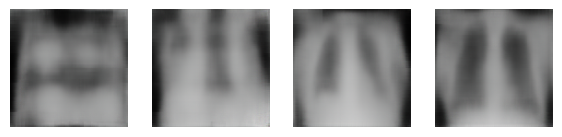

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

N = 4

vae = trainer.model
vae.eval()
# we generate a random 64-dimensional multi-gaussian vector
x = np.random.normal(0, 1, (N, 256))
x = x.astype(np.float32)
x = torch.from_numpy(x).to(trainer.device).unsqueeze(2).unsqueeze(3)

with torch.no_grad():
    rec = vae.decoder(x).detach().cpu()
    
plt.figure(figsize=(7, 5))
for i in range(N):
    plt.subplot(1, N, i+1)
    plt.imshow(rec[i].reshape(3, 128, 128).permute(1,2,0))
    plt.axis('off')
plt.show()

## 4. build a latent diffusion model (LDM)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Diffuser(nn.Module):
    def __init__(self, diff_steps, n_labels):
        super(Diffuser, self).__init__()

        self.diffusion = nn.Sequential(
            nn.Linear(256 + diff_steps + n_labels, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
        )
        
        self.diff_steps = diff_steps
        self.n_labels = n_labels

    def forward(self, x, step, label):
        
        # one hot for diffusion step
        step_encoding = F.one_hot(
            torch.tensor([step]*x.shape[0]), num_classes = self.diff_steps
        ).to(device)
        
        # one hot for label
        labels_encoding = F.one_hot(label, num_classes = self.n_labels).to(device)
        
        # concat features and run diffusion process
        emb = torch.cat([x, step_encoding, labels_encoding], 1)
        out = self.diffusion(emb)
    
        # normalize the output
        MEAN = out.mean(dim=1, keepdim=True)
        STD = out.std(dim=1, keepdim=True) + 1e-8
        out = (out - MEAN) / STD * sigma
        return out
    
diffusion_steps = 25
ldm = Diffuser(25, 4)
ldm.to(device) # move model to GPU

Diffuser(
  (diffusion): Sequential(
    (0): Linear(in_features=285, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
)

### 4.1 the noise sampler

In [12]:
### sampler
sigma = 0.24
# normal distribution sampler (we could throw to cuda for once)
unit_normal = torch.distributions.Normal(0, sigma)
unit_normal.loc = unit_normal.loc.to(device)
unit_normal.scale = unit_normal.scale.to(device)

### 4.2 the evaluation function

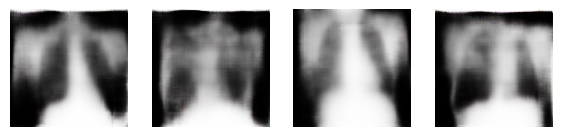

In [13]:
def evaluate(ldm, diffusion_steps):
    
    # 0, 1, 2, 3
    labels = torch.arange(4)
    
    # random images
    noisy_images = unit_normal.sample((len(labels),256)) * np.sqrt(diffusion_steps)
    
    plt.figure(figsize=(7, 5))

    # we run diffusion process for multiple steps
    # to denoise the noisy images into a digit image
    for diffusion_step in range(diffusion_steps):    
        step = diffusion_steps - diffusion_step - 1
        with torch.no_grad():
            noise = ldm(noisy_images, step, labels)
        noisy_images -= noise.view(len(labels), 256)

    for i in range(4):
        plt.subplot(1, 4, i+1)
        # print the digit one by one
        latent = noisy_images[i:i+1].unsqueeze(-1).unsqueeze(-1)
        with torch.no_grad():
            reconstruction = vae.decoder(latent)[0]
        plt.imshow(reconstruction.cpu().permute(1, 2, 0))
        plt.axis('off')
    plt.show()

evaluate(ldm, diffusion_steps)

### 4.3 training the latent diffusion model
- given image data, we first use the VAE encoder to encode them into latent space
- we run the LDM model on the latent space
- the LDM model would generate synthetic samples in latent space
- we then use the VAE decoder to decode the synthetic samples into real image space

Epoch: 0 	 Loss: 144.3587410505861


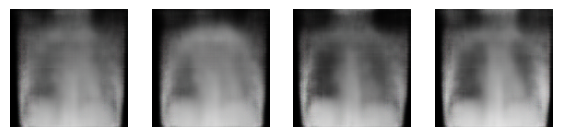

Epoch: 1 	 Loss: 136.6373864300549
Epoch: 2 	 Loss: 135.48954015411437
Epoch: 3 	 Loss: 134.957813994959
Epoch: 4 	 Loss: 134.53044639341533
Epoch: 5 	 Loss: 134.18359554558992


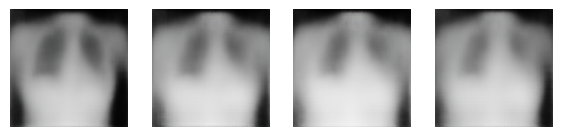

Epoch: 6 	 Loss: 133.90603378601372
Epoch: 7 	 Loss: 133.59210023190826
Epoch: 8 	 Loss: 133.56643746234477
Epoch: 9 	 Loss: 133.395203538239
Epoch: 10 	 Loss: 133.13103471137583


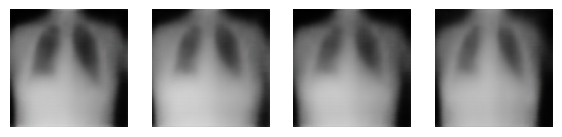

Epoch: 11 	 Loss: 133.07071513030678
Epoch: 12 	 Loss: 132.9634430082515
Epoch: 13 	 Loss: 132.86938097327948
Epoch: 14 	 Loss: 132.77730086259544
Epoch: 15 	 Loss: 132.79858641605824


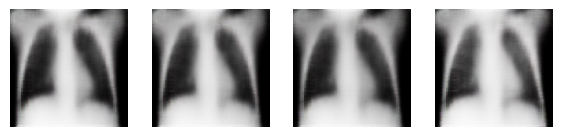

Epoch: 16 	 Loss: 132.7108307806775
Epoch: 17 	 Loss: 132.46606006100774
Epoch: 18 	 Loss: 132.55172099079937
Epoch: 19 	 Loss: 132.4601397169754
Epoch: 20 	 Loss: 132.46454588975757


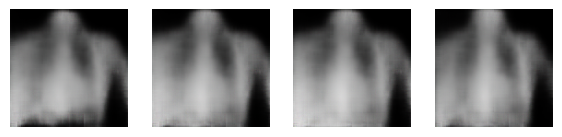

Epoch: 21 	 Loss: 132.3953073080629
Epoch: 22 	 Loss: 132.3351447628811
Epoch: 23 	 Loss: 132.276965896599
Epoch: 24 	 Loss: 132.23989922646433


In [14]:
from tqdm import tqdm

optimizer = torch.optim.Adam(ldm.parameters(), 0.1)
criterion = nn.MSELoss()

mapping = {"Normal": 0, "COVID": 1, "Lung Opacity": 2, "Viral Pneumonia":3}

for epoch in range(25):
    epoch_loss = 0
    for batch in train_dataloader:
        images = torch.stack(batch["path"], dim=0).to(device)
        labels = torch.LongTensor([mapping[item] for item in batch["label"]]).to(device)
        with torch.no_grad():
            latents = vae.encoder(images)[0]
        
        for step in torch.randperm(diffusion_steps):
            # get a sample at step: original image + sqrt(step) * normal sample
            less_noisy = latents + unit_normal.sample(latents.shape) * np.sqrt(step)
            # get a normal sample
            one_step_noise = unit_normal.sample(latents.shape)
            # get the sample at (step + 1)
            more_noisy = less_noisy + one_step_noise 
        
            output = ldm(more_noisy, step, labels)
            loss = criterion(output, one_step_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 

            epoch_loss += loss.item()
    print(f'Epoch: {epoch} \t Loss: {epoch_loss}')
    
    if epoch % 5 == 0:
        evaluate(ldm, diffusion_steps)